In [1]:
from IPython.display import Image
import pandas as pd
import csv
import dateutil

from stonesoup.plotter import AnimatedPlotterly, Plotter, Plotterly
from matplotlib import pyplot as plt

from stonesoup.types.detection import Detection
from stonesoup.models.measurement.linear import LinearGaussian

import numpy as np
from datetime import datetime, timedelta

from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState
from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, \
                                               ConstantVelocity
from stonesoup.plotter import AnimatedPlotterly

from stonesoup.predictor.kalman import KalmanPredictor
from stonesoup.updater.kalman import KalmanUpdater
from stonesoup.types.state import GaussianState

# Stone Soup
...is a software project to provide the target tracking and state estimation community with a framework for the development and testing of tracking and state estimation algorithms.
[documentation](https://stonesoup.readthedocs.io/en/latest/index.html)

 Starting with Tutorial 1 - An introduction to Stone Soup: using the Kalman filter
[Tutorial 1](https://stonesoup.readthedocs.io/en/latest/auto_tutorials/01_KalmanFilterTutorial.htmlsphx-glr-auto-tutorials-01-kalmanfiltertutorial-py)

 This notebook is designed to introduce some of the basic features of Stone Soup using a single
 target scenario and a Kalman filter as an example.

 ## Background and notation
 
 Let $ p(\mathbf{x}_{k})$, the probability distribution over $\mathbf{x}_{k} \in \mathbb{R}^n$, represent a hidden state at some discrete point
 $k$. The $k$ is most often interpreted as a timestep, but could be any sequential index (hence we don't use $t$). The measurement is given by
 $\mathbf{z}_{k} \in \mathbb{R}^m$.

 In Stone Soup, objects derived from the `State` class carry information on a variety of states, whether they be hidden states, observations, ground truth. Minimally, a state will comprise a `StateVector` and a timestamp. These can be extended. For example the `GaussianState` is parameterised by a mean state vector and a covariance matrix. (We'll see this in action later.)

 Our goal is to infer $p(\mathbf{x}_{k})$, given a sequence of measurements $\mathbf{z}_{1}, ..., \mathbf{z}_{k}$, (which we'll write as $\mathbf{z}_{1:k}$). In
 general $\mathbf{z}$ can include clutter and false alarms. We'll defer those complications to later tutorials and assume, for the moment, that all measurements are generated by a target, and that detecting the target at each timestep is certain ($p_d = 1$ and $p_{fa} = 0$).

## Prediction
 
 We proceed under the Markovian assumption that $p(\mathbf{x}_k) = \int_{-\infty} ^{\infty}
 p(\mathbf{x}_k|\mathbf{x}_{k-1}) p(\mathbf{x}_{k-1}) d \mathbf{x}_{k-1}$, meaning that the distribution over the state of an object at time $k$ can be predicted entirely from its state at previous time $k-1$. If our understanding of $p(\mathbf{x}_{k-1})$ was informed by a series of measurements up to and including timestep $k-1$, we can write
$$
           p(\mathbf{x}_k|\mathbf{z}_{1:k-1}) =
           \int_{-\infty}^{\infty} p(\mathbf{x}_k|\mathbf{x}_{k-1})
           p(\mathbf{x}_{k-1}|\mathbf{z}_{1:k-1})d \mathbf{x}_{k-1}
$$

 This is known as the *Chapman-Kolmogorov* equation. In Stone Soup we refer to this process as *prediction* and to an object that undertakes it as a `Predictor`. A predictor requires a *state transition model*, namely a function which undertakes $\mathbf{x}_{k|k-1} = f(\mathbf{x}_{k-1}, \mathbf{w}_k)$, where $\mathbf{w}_k$ is a noise term. Stone Soup has transition models derived from the `TransitionModel` class.

## Update
 
 We assume a sensor measurement is generated by some stochastic process represented by a function, $\mathbf{z}_k = h(\mathbf{x}_k, \boldsymbol{\nu}_k)$ where $\boldsymbol{\nu}_k$ is  the noise.

 The goal of the update process is to generate the *posterior state estimate*, from the prediction and the measurement. It does this by way of Bayes' rule,

$$
           p(\mathbf{x}_k | \mathbf{z}_{1:k}) =
           \frac{ p(\mathbf{z}_{k} | \mathbf{x}_k) p(\mathbf{x}_k | \mathbf{z}_{1:k-1})}
           {p(\mathbf{z}_k | \mathbf{z}_{1:k-1})}
$$

 where $p(\mathbf{x}_k | \mathbf{z}_{1:k-1})$ is the output of the prediction stage, $p(\mathbf{z}_{k} | \mathbf{x}_k)$ is known as the likelihood, and
 $p(\mathbf{z}_k | \mathbf{z}_{1:k-1})$ the evidence. In Stone Soup, this calculation is undertaken by the `Updater` class. Updaters use a `MeasurementModel` class
 which models the effect of $h(\cdot)$.

 <div>
 <img src="https://stonesoup.readthedocs.io/en/latest/_images/predict_update.png" width="500"/>
 <div>

 This figure represents a single instance of this predict-update process. It shows a prior distribution, at the bottom left, a prediction (dotted ellipse), and posterior (top right) calculated after a measurement update. We then proceed recursively, the posterior distribution at $k$ becoming the prior for the next measurement timestep, and so on.

## Simulate a target
We consider a 2d Cartesian scheme where the state vector is. That is, we’ll model the target motion as a position and velocity component in each dimension. The units used are unimportant, but do need to be consistent.

To start we’ll create a simple truth path, sampling at 1 second intervals. We’ll do this by employing one of Stone Soup’s native transition models.

These inputs are required:

In [2]:
# And the clock starts
start_time = datetime.now().replace(microsecond=0)
np.random.seed(1991)

 2D Simulation

In [3]:
q_x = 0.05
q_y = 0.05
transition_model = CombinedLinearGaussianTransitionModel([ConstantVelocity(q_x),
                                                          ConstantVelocity(q_y)])

A ‘truth path’ is created starting at (0,0) moving to the NE at one distance unit per (time) step in each dimension.

In [4]:
timesteps = [start_time]
truth = GroundTruthPath([GroundTruthState([0, 1, 0, 1], timestamp=timesteps[0])])

num_steps = 20
for k in range(1, num_steps + 1):

    timesteps.append(start_time+timedelta(seconds=k))  # add next timestep to list of timesteps
    truth.append(GroundTruthState(
        transition_model.function(truth[k-1], noise=True, time_interval=timedelta(seconds=1)),
        timestamp=timesteps[k]))

In [5]:
timesteps

[datetime.datetime(2024, 10, 22, 23, 45, 48),
 datetime.datetime(2024, 10, 22, 23, 45, 49),
 datetime.datetime(2024, 10, 22, 23, 45, 50),
 datetime.datetime(2024, 10, 22, 23, 45, 51),
 datetime.datetime(2024, 10, 22, 23, 45, 52),
 datetime.datetime(2024, 10, 22, 23, 45, 53),
 datetime.datetime(2024, 10, 22, 23, 45, 54),
 datetime.datetime(2024, 10, 22, 23, 45, 55),
 datetime.datetime(2024, 10, 22, 23, 45, 56),
 datetime.datetime(2024, 10, 22, 23, 45, 57),
 datetime.datetime(2024, 10, 22, 23, 45, 58),
 datetime.datetime(2024, 10, 22, 23, 45, 59),
 datetime.datetime(2024, 10, 22, 23, 46),
 datetime.datetime(2024, 10, 22, 23, 46, 1),
 datetime.datetime(2024, 10, 22, 23, 46, 2),
 datetime.datetime(2024, 10, 22, 23, 46, 3),
 datetime.datetime(2024, 10, 22, 23, 46, 4),
 datetime.datetime(2024, 10, 22, 23, 46, 5),
 datetime.datetime(2024, 10, 22, 23, 46, 6),
 datetime.datetime(2024, 10, 22, 23, 46, 7),
 datetime.datetime(2024, 10, 22, 23, 46, 8)]

In [6]:
plotter = AnimatedPlotterly(timesteps, tail_length=0.3)
plotter.plot_ground_truths(truth, [0, 2])
plotter.fig

We can check the Fk and Qk matrices (generated over a 1s period).

In [7]:
transition_model.matrix(time_interval=timedelta(seconds=1))

array([[1., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.]])

In [8]:
transition_model.covar(time_interval=timedelta(seconds=1))

array([[0.01666667, 0.025     , 0.        , 0.        ],
       [0.025     , 0.05      , 0.        , 0.        ],
       [0.        , 0.        , 0.01666667, 0.025     ],
       [0.        , 0.        , 0.025     , 0.05      ]])

 Simulate measurements

In [9]:
measurement_model = LinearGaussian(
    ndim_state=4,   # Number of state dimensions (position and velocity in 2D)
    mapping=(0, 2), # Mapping measurement vector index to state index
    noise_covar=np.array([[5, 0 ],  
                          [0, 5]])
    )  #Covariance matrix for Gaussian PDF

measurement_model.matrix()

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.]])

In [10]:
measurement_model.covar()

CovarianceMatrix([[5, 0],
                  [0, 5]])

Generate the measurements

In [11]:
timestamps = []
measurements = []
states = []
for state in truth:
    measurement = measurement_model.function(state, noise=True)
    states.append(measurement)
    timestamps.append(state.timestamp)
    measurements.append(Detection(measurement,
                                  timestamp=state.timestamp,
                                  measurement_model=measurement_model))
    
plotter.plot_measurements(measurements, [0, 2])
plotter.fig

### Save these measures to a csv - to test the reader

In [12]:
measures_df = pd.DataFrame({
    'timestamp': timestamps, 
    'x': [state[0] for state in states], 
    'y': [state[1] for state in states]
})
measures_df
measures_csv_file = '../../../data/tutorial1_measures.csv' 
measures_df.to_csv(measures_csv_file, index=False)

 Construct a Kalman filter

In [13]:
predictor = KalmanPredictor(transition_model)

updater = KalmanUpdater(measurement_model)

prior = GaussianState([[0], [1], [0], [1]], np.diag([1.5, 0.5, 1.5, 0.5]), timestamp=start_time)

In [14]:
from stonesoup.types.hypothesis import SingleHypothesis
from stonesoup.types.track import Track
track = Track()
for measurement in measurements:
    prediction = predictor.predict(prior, timestamp=measurement.timestamp)
    hypothesis = SingleHypothesis(prediction, measurement)   # Group a prediction and measurement
    post = updater.update(hypothesis)
    track.append(post)
    prior = track[-1]

In [15]:
plotter.plot_tracks(track, [0, 2], uncertainty=True)
plotter.fig

## Re-Doing the Example with a DataReader

In [16]:
measures_csv_file = '../../../data/tutorial1_measures.csv' 

test_data = pd.read_csv(measures_csv_file)
test_data['timestamp'] = pd.to_datetime(test_data['timestamp'])
test_data['timestamp'] = test_data['timestamp'].apply(lambda x: x.to_pydatetime())
test_data.head()

,timestamp,x,y
0,2024-10-22 23:45:48,-4.947026,0.752359
1,2024-10-22 23:45:49,0.433310,3.484353
2,2024-10-22 23:45:50,1.031607,-5.364657
3,2024-10-22 23:45:51,0.387245,1.838776
4,2024-10-22 23:45:52,3.249545,4.864842


Text(0.5, 1.0, 'Test Data')

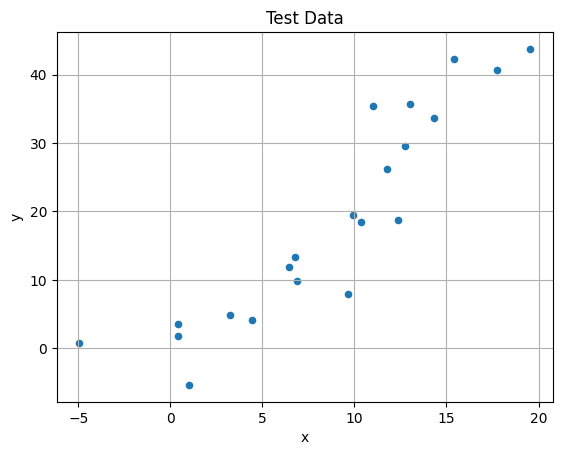

In [17]:
test_data.plot.scatter(x="x", y="y")
plt.grid()
plt.title('Test Data')

In [18]:
from stonesoup.reader import DetectionReader
from stonesoup.base import Property
from typing import Tuple
from stonesoup.buffered_generator import BufferedGenerator

class CSVReaderXY(DetectionReader):
    rdp_file: str = Property(doc="File with the radar data.")
    ndim_state: int = Property(default=4)
    pos_mapping: Tuple[int, int] = Property(default=(0, 2))
    # vel_mapping: Tuple[int, int] = Property(default=(1, 3))

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Tutorial 6 Approach
        measurement_model = LinearGaussian(
            ndim_state=4,
            mapping=(0, 2),
            noise_covar=np.array([[5, 0],
                                [0, 5]])
            )
        
        self.model=measurement_model

    @BufferedGenerator.generator_method
    def detections_gen(self):
        with open(self.rdp_file, newline='') as csv_file:
            for row in csv.DictReader(csv_file):
                if not row['timestamp']:
                    continue

                timestamp = dateutil.parser.parse(row['timestamp'], ignoretz=True)
                # lat = float(row['latitude'])
                # lon = float(row['longitude']) 
                x = float(row['x'])
                y = float(row['y'])

                yield timestamp, {Detection(
                    [x, y], timestamp=timestamp, 
                    measurement_model=self.model)}

In [25]:
# rdp = RDPReader(rdp_file,
timestamps = [x.to_pydatetime() for x in test_data['timestamp']]

meas_csv = CSVReaderXY(measures_csv_file)
dets = [next(iter(detection[1])) for detection in meas_csv.detections_gen()]

plotter = AnimatedPlotterly(timestamps, tail_length=0.3)

# Not Animated
# plotter.plot_measurements(
#         dets,
#         mapping=[0, 2],
#         measurements_label='Sample Data', 
#         color="red",
#         alpha=0.3,
#         marker="+",
#         zorder=10)

#Animated
plotter.plot_measurements(dets,
                          mapping=[0, 1],
                          measurements_label='Test Data',
                          marker=dict(color='rgba(255, 0, 0, 0.7)',
                                      size=5, 
                                      symbol="cross"),
                          convert_measurements=False
)
# plt.title("XY Data Sample")
# plt.grid()
plotter.fig

In [21]:
# Measurement Model
measurement_model = LinearGaussian(
    ndim_state=4,   # Number of state dimensions (position and velocity in 2D)
    mapping=(0, 2), # Mapping measurement vector index to state index
    noise_covar=np.array([[5, 0 ],  
                          [0, 5]])
    )  #Covariance matrix for Gaussian PDF


# Transition Model
q_x = 0.05
q_y = 0.05
transition_model = CombinedLinearGaussianTransitionModel([ConstantVelocity(q_x),
                                                          ConstantVelocity(q_y)])
predictor = KalmanPredictor(transition_model)
updater = KalmanUpdater(measurement_model)
prior = GaussianState([[0], [1], [0], [1]], np.diag([1.5, 0.5, 1.5, 0.5]), timestamp=start_time)


start_time = min(timestamps)
prior = GaussianState([[0], [1], [0], [1]], np.diag([1.5, 0.5, 1.5, 0.5]), timestamp=start_time)

from stonesoup.types.hypothesis import SingleHypothesis
from stonesoup.types.track import Track
track = Track()

for det in dets:
    prediction = predictor.predict(prior, timestamp=det.timestamp)
    # print(det.timestamp)
    hypothesis = SingleHypothesis(prediction, det)   # Group a prediction and measurement
    post = updater.update(hypothesis)
    track.append(post)
    prior = track[-1]

In [23]:
plotter = AnimatedPlotterly(timestamps, tail_length=1)
plotter.plot_measurements(dets,
                          mapping=[0, 2],
                          measurements_label='Test Data',
                          marker=dict(color='rgba(255, 0, 0, 0.7)',
                                      size=5, 
                                      symbol="cross"))

plotter.plot_tracks(track, [0, 2], uncertainty=True)

plotter.fig